In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)

/tmp/ipykernel_1880253/3010232515.py:20: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def adjust_spines(ax, spines,lw=None,movepos=None):
    ax.xaxis.set_tick_params(width=lw)
    ax.yaxis.set_tick_params(width=lw)
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', movepos))  # outward by 10 points
            spine.set_linewidth(lw)
        else:
            spine.set_color('none')  # don't draw spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

#### Read

In [3]:
############################################################################################################################################################
# uvw-heatsum
############################################################################################################################################################
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/'
file = sorted(glob.glob(folderpath+'*dict1_g_onevar'))
UVWheat = [read_and_proc.depickle(filez) for filez in file]

In [4]:
file

['/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/IR_preproc_dict1_g_onevar',
 '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/NOIR_preproc_dict1_g_onevar',
 '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/NORAD_preproc_dict1_g_onevar',
 '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/RAD_preproc_dict1_g_onevar']

In [6]:
def combine_exp(datalist=None,var=None,heateq=False):
    leftstart = [24,36-9,60-9,36-9]
    if heateq:
        data = []
        for inx,keyname in enumerate(datalist.keys()):
            data.append(datalist[keyname][int(leftstart[inx]):120,:])
        return np.concatenate([exp for exp in data],axis=0)
    else:
        data = []
        for i in range(4):
            data.append(datalist[i][var][int(leftstart[i]):120,:])
        return np.concatenate([exp for exp in data],axis=0)

In [7]:
coorpres = [1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,  550.,  525.,
        500.,  475.,  450.,  425.,  400.,  375.,  350.,  325.,  300.,  275.,
        250.,  225.,  200.,  175.,  150.,  125.,  100.,   75.,   50.]

#mydata = xr.Dataset(data_vars=dict(u=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='u',heateq=False).reshape(351,39,360,167)),
#                          v=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='v',heateq=False).reshape(351,39,360,167)),
#                          w=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='w',heateq=False).reshape(351,39,360,167)),
#                          qv=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='qv',heateq=False).reshape(351,39,360,167)),
#                          theta=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='theta',heateq=False).reshape(351,39,360,167)),
#                          Q=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat,var='heatsum',heateq=False).reshape(351,39,360,167))),
#          coords=dict(pressure=coorpres),attrs=dict(description='Data for Fourier Analysis'))

mydata_heq = xr.Dataset(data_vars=dict(rad=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat[3],var=None,heateq=True).reshape(351,39,360,167)),
                          norad=(['samples','pressure','azimuth','radius'],combine_exp(datalist=UVWheat[2],var=None,heateq=True).reshape(351,39,360,167))),
          coords=dict(pressure=coorpres),attrs=dict(description='Data for Fourier Analysis'))

#### Vertical decomposition

In [8]:
import dask
class vertical_decomp:
    def __init__(self,arraysize=39,sincomp=[0.5,1,1.5,2]):
        #self.input_data = (input_data).copy()
        self.coorpres = np.flipud(np.asarray([1000.,975.,950.,925.,900.,875.,850.,825.,800.,775.,750.,725.,700.,675.,650.,625.,600.,575.,550.,525.,500.,475.,450.,425.,\
                                              400.,375.,350.,325.,300.,275.,250.,225.,200.,175.,150.,125.,100.,75.,50.]))
        self.arraysize = arraysize
        self.sincomp = sincomp
        
    def sin_series(self):
        kern = [np.sin(i*np.linspace(0,2*np.pi,self.arraysize)) for i in [0.5,-1,-1.5,-2]]
        return kern #vstack().transpose()
    
    def out_kernpres(self):
        kern = [np.sin(i*np.linspace(0,2*np.pi,self.arraysize)) for i in [0.5,-1,-1.5,-2]]
        return kern,self.coorpres 
    
    def get_coeff(self,inputdata=None,allout=True,kern=None):
        # Fourier sine series
        if kern:
            kern=kern[:]
        else:
            kern = [(obj) for obj in self.sin_series()]
        # Output
        coor = [np.nanmean(inputdata)]
        inputt = ((inputdata)-np.nanmean(inputdata)).copy()
        tempcoor = np.trapz(inputt*np.flipud(kern[0]),dx=25)*2/(np.max(self.coorpres)-np.min(self.coorpres))
        coor.append(tempcoor)
        tempcoor2 = np.trapz((inputt-tempcoor*kern[0])*np.flipud(kern[1]),dx=25)*2/(np.max(self.coorpres)-np.min(self.coorpres))
        coor.append(tempcoor2)
        tempcoor3 = np.trapz((inputt-tempcoor*kern[0]-tempcoor2*kern[1])*np.flipud(kern[2]),dx=25)*2/(np.max(self.coorpres)-np.min(self.coorpres))
        coor.append(tempcoor3)
        tempcoor4 = np.trapz((inputt-tempcoor*kern[0]-tempcoor2*kern[1]-tempcoor3*kern[2])*np.flipud(kern[3]),dx=25)*2/(np.max(self.coorpres)-np.min(self.coorpres))
        coor.append(tempcoor4)
        
        if allout:
            return coor,kern,self.coorpres
        else:
            return coor
        
    def proc_on_array(self,array=None,printnum=10000000,kern=None):
        return [self.get_coeff((array[:,indx]),False,kern) for indx in tqdm(range(len(array[0,:])))]     
    
    def process(self,array=None,kern=None):
        temparray = np.asarray([array[:,i,:,:].flatten(order='C') for i in range(39)])
        calcmodel = np.asarray(self.proc_on_array(array=temparray[:,:],printnum=10000000,kern=kern))
        return calcmodel

In [9]:
from dask import delayed
from tqdm.dask import TqdmCallback
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar
import pandas as pd

#_,kern,pres = vertical_decomp().get_coeff(mydata['Q'][90,:,90,20],True,None)
#calc_model = []
#for indx,obj in enumerate(['u','v','w','theta']):
#    calc_model.append(vertical_decomp().process(array=mydata[obj][:,:].data,kern=kern))

##########################################################################################################
# Heat Equation
##########################################################################################################
kern,pres = vertical_decomp().out_kernpres()
calc_model = []
for indx,obj in enumerate(['rad','norad']):
    calc_model.append(vertical_decomp().process(array=mydata_heq[obj][:,:].data,kern=kern))

#indices = np.array(list(np.ndindex(mydata['Q'][:,:].data[:,0,:,:].shape)))
#df_indices = pd.DataFrame({'x': indices[:, 0], 'y': indices[:, 1], 'z': indices[:, 2]})

  0%|          | 0/21102120 [00:00<?, ?it/s]

  0%|          | 0/21102120 [00:00<?, ?it/s]

In [285]:
def test(inputdata=None):
    # Output
    coor = [np.nanmean(inputdata)]
    inputt = ((inputdata)-np.nanmean(inputdata)).copy()
    #inputt = ((inputdata)).copy()
    tempcoor = np.trapz(inputt*np.flipud(kern[0]),dx=25)*2/(np.max(coorpres)-np.min(coorpres))
    coor.append(tempcoor)
    tempcoor2 = np.trapz((inputt-tempcoor*kern[0])*np.flipud(kern[1]),dx=25)*2/(np.max(coorpres)-np.min(coorpres))
    coor.append(tempcoor2)
    tempcoor3 = np.trapz((inputt-tempcoor*kern[0]-tempcoor2*kern[1])*np.flipud(kern[2]),dx=25)*2/(np.max(coorpres)-np.min(coorpres))
    coor.append(tempcoor3)
    tempcoor4 = np.trapz((inputt-tempcoor*kern[0]-tempcoor2*kern[1]-tempcoor3*kern[2])*np.flipud(kern[3]),dx=25)*2/(np.max(coorpres)-np.min(coorpres))
    coor.append(tempcoor4)
    return coor

In [302]:
from itertools import product
import pandas as pd
A = np.random.rand(10,360,167)
x, y, z = A.shape
x_, y_, z_ = zip(*product(range(x), range(y), range(z)))
df = pd.DataFrame(A.flatten()).assign(x=x_, y=y_, z=z_)
df

,0,x,y,z
0,0.196670,0,0,0
1,0.324506,0,0,1
2,0.698119,0,0,2
3,0.509760,0,0,3
4,0.050129,0,0,4
...,...,...,...,...
601195,0.972924,9,359,162
601196,0.407855,9,359,163
601197,0.734774,9,359,164
601198,0.446931,9,359,165


In [9]:
a = [calcmodel[i,0]+np.flipud(kern[0])*calcmodel[i,1]+np.flipud(kern[1])*calcmodel[i,2]+np.flipud(kern[2])*calcmodel[i,3]+\
     np.flipud(kern[3])*calcmodel[i,4] for i in tqdm(range(len(calcmodel[:,0])))]

  0%|          | 0/21102120 [00:00<?, ?it/s]

In [10]:
read_and_proc.save_to_pickle('../output/spectral/vert_decomp/RADweights',calc_model[0],'PICKLE')
read_and_proc.save_to_pickle('../output/spectral/vert_decomp/NORADweights',calc_model[1],'PICKLE')
#read_and_proc.save_to_pickle('../output/spectral/vert_decomp/Wweights',calc_model[2],'PICKLE')
#read_and_proc.save_to_pickle('../output/spectral/vert_decomp/THETAweights',calc_model[3],'PICKLE')


#read_and_proc.save_to_pickle('../output/spectral/vert_decomp/Qreconstruct',a,'PICKLE')

In [11]:
read_and_proc.save_to_pickle('../output/spectral/vert_decomp/df_indices',df_indices,'PICKLE')

#### Read stuff

In [16]:
class vertical_decomp_recover:
    def __init__(self,weight=None,kern=None,compno=4):
        self.weight=weight
        self.kern = kern
        self.compno=compno
    def emulate(self):
        if self.compno==4:
            a = [self.weight[i,0]+np.flipud(self.kern[0])*self.weight[i,1]+np.flipud(self.kern[1])*self.weight[i,2]+np.flipud(self.kern[2])*self.weight[i,3]+np.flipud(self.kern[3])*self.weight[i,4] for i in tqdm(range(len(self.weight[:,0])))]
        elif self.compno==3:
            a = [self.weight[i,0]+np.flipud(self.kern[0])*self.weight[i,1]+np.flipud(self.kern[1])*self.weight[i,2]+np.flipud(self.kern[2])*self.weight[i,3] for i in tqdm(range(len(self.weight[:,0])))]        
        elif self.compno==2:
            a = [self.weight[i,0]+np.flipud(self.kern[0])*self.weight[i,1]+np.flipud(self.kern[1])*self.weight[i,2] for i in tqdm(range(len(self.weight[:,0])))]
        elif self.compno==1:
            a = [self.weight[i,0]+np.flipud(self.kern[0])*self.weight[i,1] for i in tqdm(range(len(self.weight[:,0])))]
        return np.asarray(a).flatten()
    def get_r2(self,array=None):
        from sklearn.metrics import r2_score
        a2 = ((np.asarray([array[:,i,:,:].flatten(order='C') for i in range(39)])).transpose()).flatten()
        b2 = self.emulate()
        return r2_score(a2,b2),a2,b2

In [7]:
_,kern,pres = vertical_decomp().get_coeff(mydata['Q'][90,:,90,20],True,None)
path = '../output/spectral/vert_decomp/'
U,V,W,THETA,Q = read_and_proc.depickle(path+'Uweights'),read_and_proc.depickle(path+'Vweights'),read_and_proc.depickle(path+'Wweights'),read_and_proc.depickle(path+'THETAweights'),read_and_proc.depickle(path+'Qweights')

In [11]:
U_r2,V_r2,W_r2,THETA_r2 = vertical_decomp_recover(U,kern,4).get_r2(mydata['u'].data),vertical_decomp_recover(V,kern,4).get_r2(mydata['v'].data),vertical_decomp_recover(W,kern,4).get_r2(mydata['w'].data),vertical_decomp_recover(THETA,kern,4).get_r2(mydata['theta'].data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21102120/21102120 [06:02<00:00, 58284.05it/s]


In [12]:
U_r2,V_r2,W_r2,THETA_r2

(0.8485461656397221,
 0.8796491598157559,
 0.8364174432837307,
 0.27846660820432356)

In [14]:
_,vertical_decomp_recover(THETA,kern,4).get_r2(mydata['theta'].data)

0.8441769284528241

In [ ]:
_,tvertical_decomp_recover(THETA,kern,4).get_r2(mydata['theta'].data)

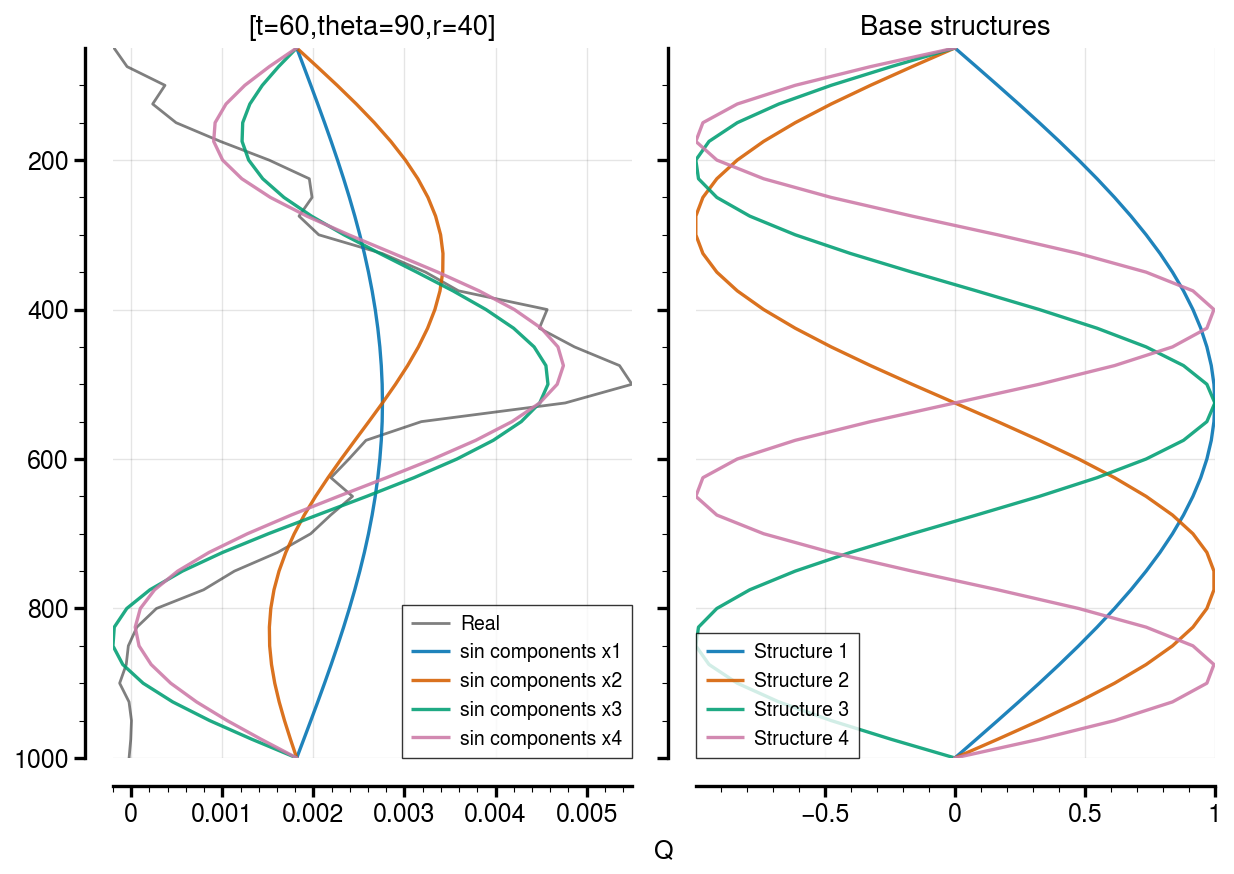

In [384]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=2.595,refaspect=0.731)
axs[0].plot(mydata['Q'][89,:,90,30],coorpres,label='Real',color='k',lw=1,alpha=0.5)
axs[0].plot(np.nanmean(mydata['Q'][89,:,90,30])+np.flipud(kern[0])*calcmodel[556140,1],coorpres,lw=1.2,alpha=0.88,label='sin components x1')
axs[0].plot(np.nanmean(mydata['Q'][89,:,90,30])+np.flipud(kern[0])*calcmodel[556140,1]+np.flipud(kern[1])*calcmodel[556140,2],coorpres,lw=1.2,alpha=0.88,label='sin components x2')
axs[0].plot(np.nanmean(mydata['Q'][89,:,90,30])+np.flipud(kern[0])*calcmodel[556140,1]+np.flipud(kern[1])*calcmodel[556140,2]+np.flipud(kern[2])*calcmodel[556140,3],coorpres,lw=1.2,alpha=0.88,label='sin components x3')
axs[0].plot((a),coorpres,lw=1.2,alpha=0.88,label='sin components x4')
axs[0].legend(prop={'size':7},ncols=1,loc=1)
axs[0].format(ylim=[1000,50],title='[t=60,theta=90,r=40]')
axs[0].invert_xaxis()
adjust_spines(axs[0],['bottom','left'],1.2,10)

axs[1].plot(kern[0],coorpres,lw=1.2,alpha=0.88,label='Structure 1')
axs[1].plot(kern[1],coorpres,lw=1.2,alpha=0.88,label='Structure 2')
axs[1].plot(kern[2],coorpres,lw=1.2,alpha=0.88,label='Structure 3')
axs[1].plot(kern[3],coorpres,lw=1.2,alpha=0.88,label='Structure 4')
axs[1].legend(prop={'size':7},ncols=1,loc=3)
axs[1].format(ylim=[1000,50],title='Base structures')
axs[1].invert_xaxis()
adjust_spines(axs[1],['bottom','left'],1.2,10)
plt.show()

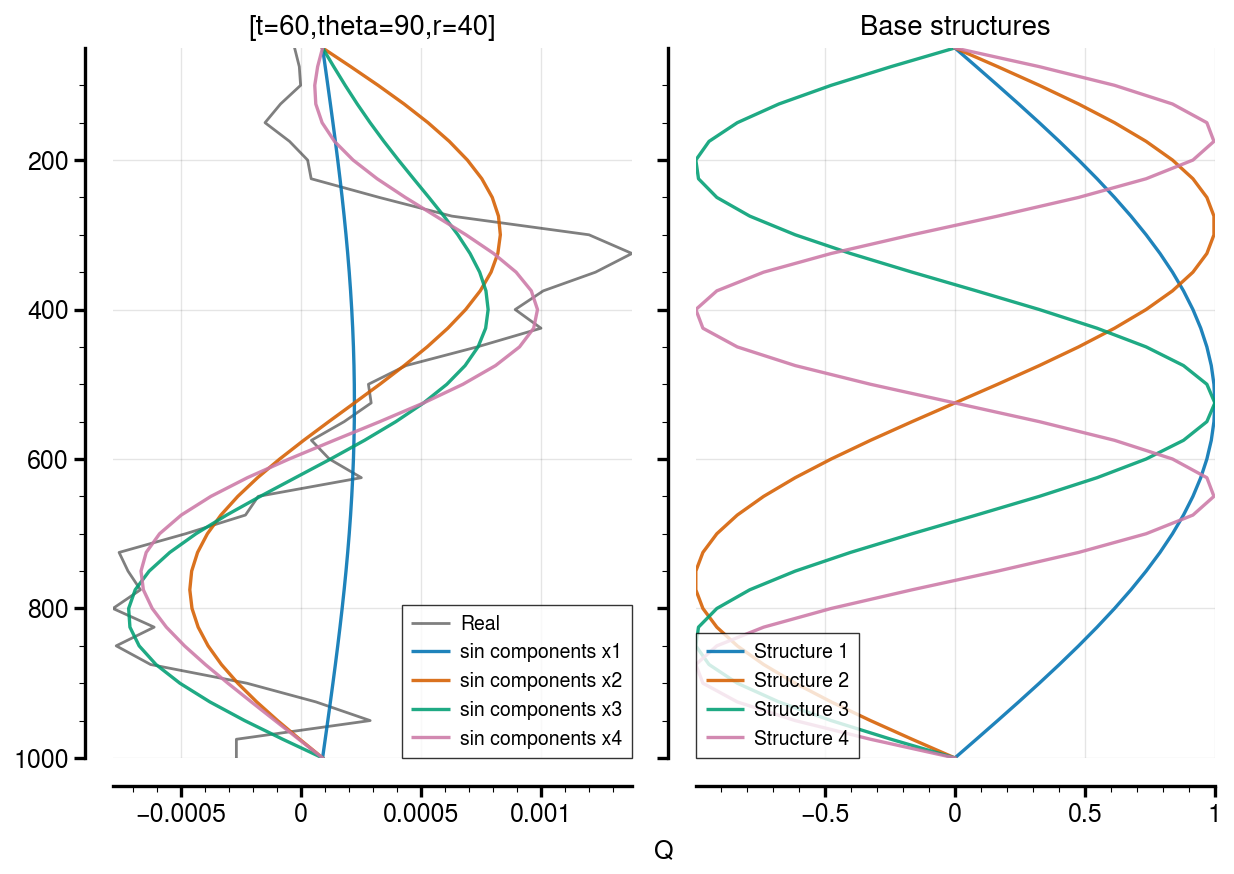

In [112]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=2.595,refaspect=0.731)
axs[0].plot(mydata['Q'][90,:,90,20],coorpres,label='Real',color='k',lw=1,alpha=0.5)
axs[0].plot(coof[0]+kern[0]*coof[0+1],coorpres,lw=1.2,alpha=0.88,label='sin components x1')
axs[0].plot(coof[0]+kern[0]*coof[0+1]+kern[1]*coof[1+1],coorpres,lw=1.2,alpha=0.88,label='sin components x2')
axs[0].plot(coof[0]+kern[0]*coof[0+1]+kern[1]*coof[1+1]+kern[2]*coof[2+1],coorpres,lw=1.2,alpha=0.88,label='sin components x3')
axs[0].plot(coof[0]+kern[0]*coof[0+1]+kern[1]*coof[1+1]+kern[2]*coof[2+1]+kern[3]*coof[3+1],coorpres,lw=1.2,alpha=0.88,label='sin components x4')
axs[0].legend(prop={'size':7},ncols=1,loc=1)
axs[0].format(ylim=[1000,50],title='[t=60,theta=90,r=40]')
axs[0].invert_xaxis()
adjust_spines(axs[0],['bottom','left'],1.2,10)

axs[1].plot(kern[0],coorpres,lw=1.2,alpha=0.88,label='Structure 1')
axs[1].plot(kern[1],coorpres,lw=1.2,alpha=0.88,label='Structure 2')
axs[1].plot(kern[2],coorpres,lw=1.2,alpha=0.88,label='Structure 3')
axs[1].plot(kern[3],coorpres,lw=1.2,alpha=0.88,label='Structure 4')
axs[1].legend(prop={'size':7},ncols=1,loc=3)
axs[1].format(ylim=[1000,50],title='Base structures')
axs[1].invert_xaxis()
adjust_spines(axs[1],['bottom','left'],1.2,10)
plt.show()